In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
%%time

twitter_df = spark.read.parquet('gs://file-name')


CPU times: user 4.17 ms, sys: 831 µs, total: 5 ms
Wall time: 6.97 s


In [6]:
twitter_df.count()

16863979

In [7]:
original = twitter_df.withColumn("retweeted_status", when(twitter_df.retweeted_status.isNull(), twitter_df.retweeted_status))

In [8]:
original

text,Organization,id,retweeted_status
rt @sahealth: twi...,Other,1453450037011181568,null
cigarette sales i...,Other,1453450036793257984,null
rt @nytimes: merc...,Influencer,1453450037481115650,null
rt @billgates: go...,Other,1453450037757833218,null
rt @carlossimanca...,Other,1453450037946634240,null
post covid? we ar...,Other,1453450039121039360,null
rt @angie_rasmuss...,Other,1453450039439863820,null
rt @pn_1984: we a...,Other,1453450040605880327,null
@sharla_evans @hu...,Other,1453450040685518857,null
.@govchrissununu ...,Other,1453450041692200960,null


In [9]:
health_raw = original.filter(original.Organization == 'Health')

In [10]:
health_raw

text,Organization,id,retweeted_status
rt @allergykidsdo...,Health,1453450098776567809,null
vaccinated outsid...,Health,1453450184738889732,null
rt @helenbranswel...,Health,1453450273901490177,null
rt @cmarinucci: t...,Health,1452701713568124930,null
1/3 #covid19 key ...,Health,1452701808011448321,null
rt @riccimike: bo...,Health,1452701826910986243,null
rt @cityofhamilto...,Health,1450119393447272455,null
rt @ameracadpeds:...,Health,1455978304058662914,null
rt @benryanwriter...,Health,1455978340955791367,null
ontario targeting...,Health,1455978359855501313,null


In [11]:
health_raw2 = health_raw.select(['text'])

In [12]:
health_raw2.printSchema()

root
 |-- text: string (nullable = true)



In [13]:
text = health_raw2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [15]:
#row = Row('text')
#df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [16]:
df_text.count()

59565

In [17]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @allergykidsdoc:, am, board, certified, immunologist., my, wife, is, pediatric, er, physician.\n\ni've, followed, #covid, vaccine, data, in, teens, &amp;…]",0
1,"[vaccinated, outside, the, u.s.?, you’re, considered, fully, vaccinated, if, you’ve, received, dose, of, the, johnson, &amp;, johnson…, https://t.co/jnmktkbqe9]",1
2,"[rt, @helenbranswell:, the, draft, agenda, for, next, week's, #acip, meeting, is, up., no, surprise:, tuesday, is, about, covid, vaccines., (read:, pfizer's, ped…]",2
3,"[rt, @cmarinucci:, three, california, teens, developed, psychosis, after, covid., here's, what, scientists, say, about, the, cases, https://t.co/cxsmviz48p…]",3
4,"[1/3, #covid19, key, concerns, 🇨🇦, weekend, numbers, pending,, surveillance, data, as, of, oct, 22, show, continued, decline, in, di…, https://t.co/62mp5krbrq]",4


In [18]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [19]:
df_tokens.count()

59565

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [21]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @allergykidsdoc:, am, board, certified, immunologist., my, wife, is, pediatric, er, physician.\n\ni've, followed, #covid, vaccine, data, in, teens, &amp;…]",0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[vaccinated, outside, the, u.s.?, you’re, considered, fully, vaccinated, if, you’ve, received, dose, of, the, johnson, &amp;, johnson…, https://t.co/jnmktkbqe9]",1,"(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @helenbranswell:, the, draft, agenda, for, next, week's, #acip, meeting, is, up., no, surprise:, tuesday, is, about, covid, vaccines., (read:, pfizer's, ped…]",2,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @cmarinucci:, three, california, teens, developed, psychosis, after, covid., here's, what, scientists, say, about, the, cases, https://t.co/cxsmviz48p…]",3,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[1/3, #covid19, key, concerns, 🇨🇦, weekend, numbers, pending,, surveillance, data, as, of, oct, 22, show, continued, decline, in, di…, https://t.co/62mp5krbrq]",4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [22]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [23]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,[rt @drjootz: her...,"[rt, @drjootz:, h...","(118503,[1,2,7,9,...","[[2027525.0], [1...."
29,[thank you to the...,"[thank, you, to, ...","(118503,[0,1,3,5,...","[[4.7945584E7], [..."
474,[rt @govcanhealth...,"[rt, @govcanhealt...","(118503,[2,4,41,1...","[[1.34740341E8], ..."
964,[rt @jennifernuzz...,"[rt, @jennifernuz...","(118503,[0,2,8,29...","[[4.7945584E7], [..."
1677,[👋 𝗦𝗧𝗔𝗙𝗙: j...,"[𝗦𝗧𝗔𝗙𝗙:, joi...","(118503,[0,1,4,17...","[[4.7945584E7], [..."


In [24]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.428571,1224,21875,"(rt @northbristolnhs: it’s easy for us to pass on covid-19 or flu viruses without knowing. this winter there are two essential vaccines you’…,)","(it’s easy for us to pass on #covid19 or #flu viruses without knowing. \n\nthis winter there are two essential vaccine… https://t.co/lgjkyovna0,)"
1,0.461538,6129,12610,"(flu and covid-19 can both be life-threatening and spread more easily in winter. \n\nif you have a long term health co… https://t.co/1piinbs33w,)","(flu and covid-19 can both be life-threatening, and spread more easily in winter. if you suffer with a long term hea… https://t.co/u4njdgdlx8,)"
2,0.000000,12881,38426,"(rt @cdcgov: cdc accepted the advisory committee on immunization practices’ (acip) recommendation that children ages 5–11 be vaccinated agai…,)","(rt @cdcgov: cdc accepted the advisory committee on immunization practices’ (acip) recommendation that children ages 5–11 be vaccinated agai…,)"
3,0.000000,18986,35504,"(rt @natwellbeinghub: we’re still learning about #longcovid and it’s impact. what we do know is it’s worth talking about.\nthat’s why we’ve p…,)","(rt @natwellbeinghub: we’re still learning about #longcovid and it’s impact. what we do know is it’s worth talking about.\nthat’s why we’ve p…,)"
4,0.478261,48693,50498,"(@deamazing1 @aircanada @deamazing1 at the moment, our covid-19 rt-lamp home collection kits are sold out due to inc… https://t.co/glgcowzr93,)","(@herbert24466251 @herbert24466251 hi herbert, at the moment, our covid-19 rt-lamp kits are sold out due to incred… https://t.co/asn6jaqoyj,)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  59565
Duplicate titles based on { 0.5 } jaccard distance:  22951
Unique titles based on { 0.5 } jaccard distance:  0.5 :  36614


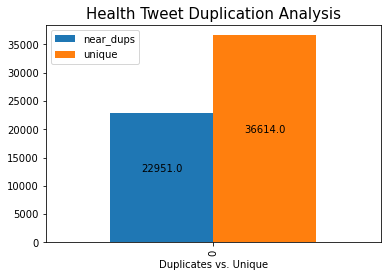

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Health Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 